<a href="https://colab.research.google.com/github/CZchikage/MUST/blob/main/MUST_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

import random
import numpy as np
import pandas as pd
from math import log, exp, isnan
import time

from scipy.special import comb
from scipy.stats import norm
from scipy.optimize import root_scalar

import matplotlib.pyplot as plt

In [ ]:
# Batch sampling methods
def OW(x, b, m):
    xb = np.random.choice(x, size=b, replace=False)  # Without replacement
    xOW = np.random.choice(xb, size=m, replace=True)  # With replacement from xb
    return xOW

def WO(x, b, m):
    xb = np.random.choice(x, size=b, replace=True)  # With replacement
    xWO = np.random.choice(xb, size=m, replace=False)  # Without replacement from xb
    return xWO

def WW(x, b, m):
    xb = np.random.choice(x, size=b, replace=True)  # With replacement
    xWW = np.random.choice(xb, size=m, replace=True)  # With replacement again
    return xWW

def WR(x, m):
    return np.random.choice(x, size=m, replace=True)  # With replacement

def WOR(x, m):
    return np.random.choice(x, size=m, replace=False)  # Without replacement

def Poisson(x, q):
    random_values = np.random.rand(len(x))
    return x[random_values < q]

def compute_sigma(sensitivity, eps, n):
    delta = 1 / n
    def delta_function(sigma):
        theta = sensitivity / (n * sigma)
        term1 = norm.cdf(-eps / theta + theta / 2)
        term2 = np.exp(eps) * norm.cdf(-eps / theta - theta / 2)
        return term1 - term2 - delta

    result = root_scalar(delta_function, bracket=[1e-10, 100], method='brentq')
    return result.root


In [ ]:
# DP-SGD with clipping and noise addition
class DP_SGD_NN(nn.Module):
    def __init__(self):
        super(DP_SGD_NN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return self.softmax(x)


def train_DP_SGD(model, train_data, test_loader, stepsize, subsample_method,  C, TT, eps_prime, b, m):

    optimizer = optim.SGD(model.parameters(), lr=stepsize)
    loss_fn = nn.CrossEntropyLoss()

    n = len(train_data)
    all_indices = np.arange(n)
    loss_history = []

    if subsample_method == 'OW':
        eps_H = log(1 + (exp(eps_prime) - 1) / ((b / n) * (1 - (1 - 1 / b) ** m)))
        sigma = compute_sigma(C, eps_H, n)
    elif subsample_method == 'WO':
        j_values = np.arange(1, b + 1)

        choose_b_j = comb(b, j_values)
        term1 = (1 / n) ** j_values     # (1/n)^j
        term2 = (1 - 1 / n) ** (b - j_values)  # (1 - 1/n)^(b - j)

        WO_terms = choose_b_j * term1 * term2 * (1 - comb(b - j_values, m) / comb(b, m))
        eps_WO = log(1 + (exp(eps_prime) - 1) / np.nansum(WO_terms))
        sigma = compute_sigma(C, eps_WO, n)

    elif subsample_method == 'WW':
        j_values = np.arange(1, b + 1)

        choose_b_j = comb(b, j_values)
        term1 = (1 / n) ** j_values     # (1/n)^j
        term2 = (1 - 1 / n) ** (b - j_values)  # (1 - 1/n)^(b - j)
        term3 = (1 - (1 - j_values / b) ** m)  # (1 - (1 - j/b)^m)

        WW_terms = choose_b_j * term1 * term2 * term3
        eps_WW = log(1 + (exp(eps_prime) - 1) / np.nansum(WW_terms))
        sigma = compute_sigma(C, eps_WW, n)

    elif subsample_method == 'WR':
        eps_WR = log(1 + (exp(eps_prime) - 1) / (1 - (1 - 1 / n) ** m))
        sigma = compute_sigma(C, eps_WR, n)

    elif subsample_method == 'WOR':
        eps_WOR = log(1 + (exp(eps_prime) - 1) / (m / n))
        sigma = compute_sigma(C, eps_WOR, n)

    elif subsample_method == 'Poisson':
        sigma = 0

    elif subsample_method == 'fully-non private':
        sigma = 0

    elif subsample_method == 'DP-Poisson':
        eps_Poisson = log(1 + (exp(eps_prime) - 1) / (m / n))
        sigma = compute_sigma(C, eps_Poisson, n)

    grad_ori = torch.zeros(TT)  # Initialize for recording original gradients
    grad_noisy = torch.zeros(TT)  # Initialize for recording noisy gradients
    time_record = [] # Initialize for recording time elapsed

    for epoch in range(TT):
        epoch_loss = 0 # Initialize for accumulate loss across data points for 1 epoch
        start_time = time.time()

        # Batch subsampling
        if subsample_method == 'OW':
            sampled_indices = OW(all_indices, b=b, m=m)
        elif subsample_method == 'WO':
            sampled_indices = WO(all_indices, b=b, m=m)
        elif subsample_method == 'WW':
            sampled_indices = WW(all_indices, b=b, m=m)
        elif subsample_method == 'WR':
            sampled_indices = WR(all_indices, m=m)
        elif subsample_method == 'WOR':
            sampled_indices = WOR(all_indices, m=m)
        elif subsample_method == 'Poisson' or "DP-Poisson":
            sampled_indices = Poisson(all_indices, m/n)
        elif subsample_method == 'fully non-private':
            sampled_indices = np.random.choice(all_indices, size=m, replace=False)

        # Step 1: Initialize gradients
        optimizer.zero_grad()

        # Step 2: Identify unique indices and their frequencies
        unique_indices, counts = np.unique(sampled_indices, return_counts=True)

        # Step 3: Initialize tensors to store weighted gradients
        grad_sum = {name: torch.zeros_like(param) for name, param in model.named_parameters()}

        # Step 4: Calculate weighted average of gradients based on frequency
        for i, idx in enumerate(unique_indices):
            Xi = train_data[idx][0]  # Get input data for the unique index
            yi = train_data[idx][1]  # Get label for the unique index

            # Ensure that Xi and yi have a batch dimension
            Xi = Xi.unsqueeze(0).to(device)  # Add batch dimension and move to the device
            yi = torch.tensor([yi]).to(device)  # Ensure label is a tensor and move to the device

            # Forward pass for each unique index
            outputs = model(Xi)
            loss = loss_fn(outputs, yi)
            loss.backward(retain_graph=True) # Compute gradients for this unique index
            epoch_loss += loss.item()

            # Store gradients and accumulate them with weights (counts[i])
            for name, param in model.named_parameters():
                if param.grad is not None:
                    grad_sum[name] += param.grad * counts[i]  # Weighted sum of gradients

        # Step 5: Final weighted average of gradients
        for name, param in model.named_parameters():
            if param.grad is not None:
                param.grad.data = grad_sum[name] / len(sampled_indices)
        # for epoch in range(num_epochs):
        #     model.train()
        #     for data, target in train_loader:
        #         optimizer.zero_grad()
        #         output = model(data)
        #         loss = criterion(output, target)
        #         loss.backward()
        #         optimizer.step()
        # Step 6: Clip gradients by the L2 norm
        total_norm = 0
        for param in model.parameters():
            total_norm += param.grad.data.norm(2).item() ** 2
        total_norm = np.sqrt(total_norm)

        if subsample_method != "Poisson" or "fully non-private":
          clip_coeff = min(1, C / total_norm)
          for param in model.parameters():
              param.grad.data.mul_(clip_coeff)  # Clip gradients

          grad_ori[epoch] = param.grad.data[0]  # Store original gradients
          # Step 7: Add noise for differential privacy
          for param in model.parameters():
              noise = torch.randn_like(param.grad) * sigma  # Add Gaussian noise
              param.grad.add_(noise)
          grad_noisy[epoch] = param.grad.data[0] # Store noisy gradients

        # Step 8: Update model parameters
        optimizer.step()

        epoch_loss /= len(unique_indices)
        loss_history.append(epoch_loss)  # Store loss for this epoch
        grad_diff_mean = (grad_noisy[epoch] - grad_ori[epoch]).mean().item()
        end_time = time.time()
        time_record.append(end_time - start_time)

        # Print result for every epoch
        print(f"Epoch {epoch+1}/{TT}, Loss: {epoch_loss:.4f}, grad_diff: {grad_diff_mean:.4f}, time: {end_time - start_time: 4f}")

    # Plot the loss curve
    plt.plot(range(1, TT + 1), loss_history, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()

    # Test accuracy
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    # Calculate accuracy
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    return grad_ori, grad_noisy, loss_history, time_record, accuracy


In [ ]:
# Prepare the dataset and dataloader
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [ ]:
print([len(train_data), len(test_data)])


[60000, 10000]


In [ ]:
# Parameter setting
seed=123
C=2
TT=300
eps_prime = 1e-5
lr = 0.3
b=3000
m=2000
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


In [ ]:
columns = ['Poisson', 'DP-Poisson', 'WR', 'WOR', 'MUST.ww', 'MUST.wo', 'MUST.ow']
final_loss = pd.DataFrame(index=range(1, TT + 1), columns=columns)
time_record_final = pd.DataFrame(index=range(1, TT + 1), columns=columns)
accuracy_final = pd.DataFrame(index = range(1), columns=columns)

Epoch 1/300, Loss: 2.3210, grad_diff: 0.0000, time:  2.775334
Epoch 2/300, Loss: 2.0862, grad_diff: 0.0000, time:  3.729732
Epoch 3/300, Loss: 2.1463, grad_diff: 0.0000, time:  4.054127
Epoch 4/300, Loss: 2.0392, grad_diff: 0.0000, time:  3.022801
Epoch 5/300, Loss: 1.8980, grad_diff: 0.0000, time:  2.613091
Epoch 6/300, Loss: 2.0972, grad_diff: 0.0000, time:  2.935907
Epoch 7/300, Loss: 1.8852, grad_diff: 0.0000, time:  2.602427
Epoch 8/300, Loss: 1.6528, grad_diff: 0.0000, time:  3.564029
Epoch 9/300, Loss: 1.6739, grad_diff: 0.0000, time:  3.019805
Epoch 10/300, Loss: 1.6909, grad_diff: 0.0000, time:  2.645357
Epoch 11/300, Loss: 2.1538, grad_diff: 0.0000, time:  2.635985
Epoch 12/300, Loss: 1.7798, grad_diff: 0.0000, time:  2.700567
Epoch 13/300, Loss: 1.6972, grad_diff: 0.0000, time:  3.301751
Epoch 14/300, Loss: 1.8665, grad_diff: 0.0000, time:  3.341920
Epoch 15/300, Loss: 1.7093, grad_diff: 0.0000, time:  2.593003
Epoch 16/300, Loss: 1.4311, grad_diff: 0.0000, time:  2.629999
E

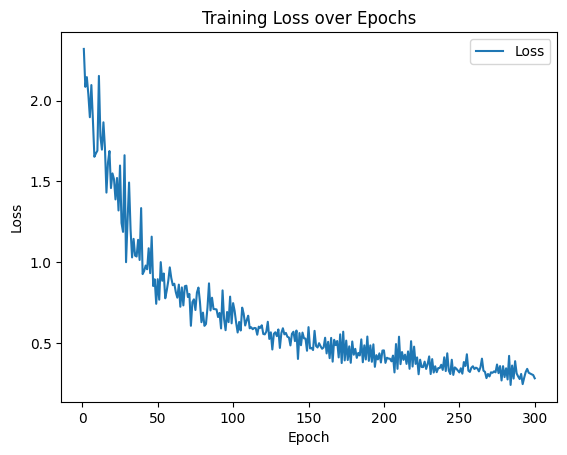

Test Accuracy: 88.28%
      Poisson DP-Poisson   WR  WOR MUST.ww MUST.wo MUST.ow
1    2.321009        NaN  NaN  NaN     NaN     NaN     NaN
2    2.086199        NaN  NaN  NaN     NaN     NaN     NaN
3    2.146337        NaN  NaN  NaN     NaN     NaN     NaN
4    2.039199        NaN  NaN  NaN     NaN     NaN     NaN
5    1.897972        NaN  NaN  NaN     NaN     NaN     NaN
..        ...        ...  ...  ...     ...     ...     ...
296  0.315222        NaN  NaN  NaN     NaN     NaN     NaN
297  0.310193        NaN  NaN  NaN     NaN     NaN     NaN
298  0.305405        NaN  NaN  NaN     NaN     NaN     NaN
299  0.300945        NaN  NaN  NaN     NaN     NaN     NaN
300  0.280864        NaN  NaN  NaN     NaN     NaN     NaN

[300 rows x 7 columns]


In [ ]:
# Training with non-private Poisson sampling
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DP_SGD_NN().to(device)

grad_ori, grad_noisy, loss_history, time_record, accuracy = train_DP_SGD(model, train_data, test_loader, stepsize=lr, subsample_method='Poisson', C=C, TT=TT, eps_prime=eps_prime, b=b, m=m)

final_loss['Poisson'] = loss_history
time_record_final["Poisson"] = time_record
accuracy_final["Poisson"] = accuracy

print(final_loss)

Epoch 1/300, Loss: 2.3210, grad_diff: -0.1240, time:  2.678520
Epoch 2/300, Loss: 2.2942, grad_diff: -0.0574, time:  2.640765
Epoch 3/300, Loss: 2.8013, grad_diff: 0.0888, time:  3.092571
Epoch 4/300, Loss: 2.6960, grad_diff: -0.1191, time:  4.003262
Epoch 5/300, Loss: 2.8163, grad_diff: -0.1017, time:  2.587965
Epoch 6/300, Loss: 2.4926, grad_diff: -0.1019, time:  2.579013
Epoch 7/300, Loss: 2.5766, grad_diff: 0.0093, time:  2.707502
Epoch 8/300, Loss: 2.2390, grad_diff: 0.1013, time:  3.075233
Epoch 9/300, Loss: 2.5018, grad_diff: -0.0465, time:  3.634356
Epoch 10/300, Loss: 2.6603, grad_diff: -0.1035, time:  3.754904
Epoch 11/300, Loss: 2.5851, grad_diff: -0.1703, time:  2.521683
Epoch 12/300, Loss: 2.1564, grad_diff: -0.1377, time:  2.723575
Epoch 13/300, Loss: 2.1428, grad_diff: -0.0379, time:  3.293751
Epoch 14/300, Loss: 2.5155, grad_diff: 0.1351, time:  3.006215
Epoch 15/300, Loss: 1.8664, grad_diff: 0.0163, time:  2.562067
Epoch 16/300, Loss: 1.9954, grad_diff: 0.1659, time:  

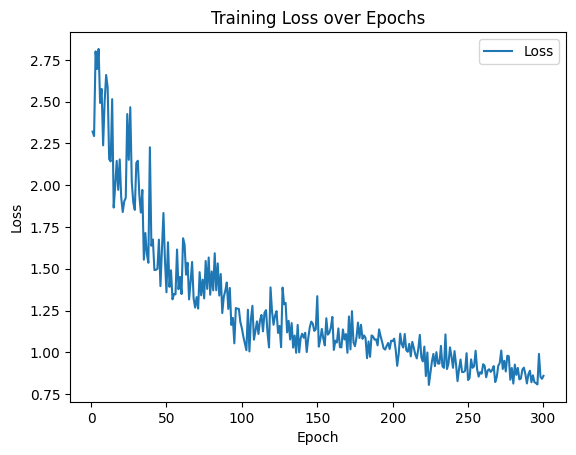

Test Accuracy: 76.14%
      Poisson  DP-Poisson   WR  WOR MUST.ww MUST.wo MUST.ow
1    2.321009    2.321009  NaN  NaN     NaN     NaN     NaN
2    2.086199    2.294240  NaN  NaN     NaN     NaN     NaN
3    2.146337    2.801340  NaN  NaN     NaN     NaN     NaN
4    2.039199    2.696011  NaN  NaN     NaN     NaN     NaN
5    1.897972    2.816264  NaN  NaN     NaN     NaN     NaN
..        ...         ...  ...  ...     ...     ...     ...
296  0.315222    0.807388  NaN  NaN     NaN     NaN     NaN
297  0.310193    0.990323  NaN  NaN     NaN     NaN     NaN
298  0.305405    0.852736  NaN  NaN     NaN     NaN     NaN
299  0.300945    0.841191  NaN  NaN     NaN     NaN     NaN
300  0.280864    0.858772  NaN  NaN     NaN     NaN     NaN

[300 rows x 7 columns]


In [ ]:
# Training with DP Poisson sampling
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DP_SGD_NN().to(device)

grad_ori, grad_noisy, loss_history, time_record, accuracy = train_DP_SGD(model, train_data, test_loader, stepsize=lr, subsample_method='DP-Poisson', C=C, TT=TT, eps_prime=eps_prime, b=b, m=m)

final_loss['DP-Poisson'] = loss_history
time_record_final["DP-Poisson"] = time_record
accuracy_final["DP-Poisson"] = accuracy

print(final_loss)

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks')

In [ ]:
final_loss.to_csv("final_loss.csv", index = False)
time_record_final.to_csv("time_record_final.csv", index = False)
accuracy_final.to_csv("accuracy_final.csv", index = False)

<ipython-input-218-57cc7ab31e65>:48: RuntimeWarning: invalid value encountered in multiply
  WW_terms = choose_b_j * term1 * term2 * term3


Epoch 1/300, Loss: 2.3236, grad_diff: -0.0983, time:  2.181696
Epoch 2/300, Loss: 2.1986, grad_diff: -0.0455, time:  1.883602
Epoch 3/300, Loss: 2.4835, grad_diff: 0.0704, time:  1.873906
Epoch 4/300, Loss: 2.4577, grad_diff: -0.0945, time:  1.870473
Epoch 5/300, Loss: 2.4923, grad_diff: -0.0806, time:  1.988956
Epoch 6/300, Loss: 2.3212, grad_diff: -0.0808, time:  2.126441
Epoch 7/300, Loss: 2.1327, grad_diff: 0.0074, time:  2.556587
Epoch 8/300, Loss: 1.9280, grad_diff: 0.0803, time:  2.216820
Epoch 9/300, Loss: 1.9748, grad_diff: -0.0369, time:  1.908876
Epoch 10/300, Loss: 2.1603, grad_diff: -0.0821, time:  2.001295
Epoch 11/300, Loss: 1.7700, grad_diff: -0.1350, time:  1.979944
Epoch 12/300, Loss: 2.1982, grad_diff: -0.1092, time:  1.907418
Epoch 13/300, Loss: 2.0497, grad_diff: -0.0301, time:  2.296268
Epoch 14/300, Loss: 2.2246, grad_diff: 0.1071, time:  2.795196
Epoch 15/300, Loss: 2.0588, grad_diff: 0.0129, time:  2.117842
Epoch 16/300, Loss: 1.8288, grad_diff: 0.1315, time:  

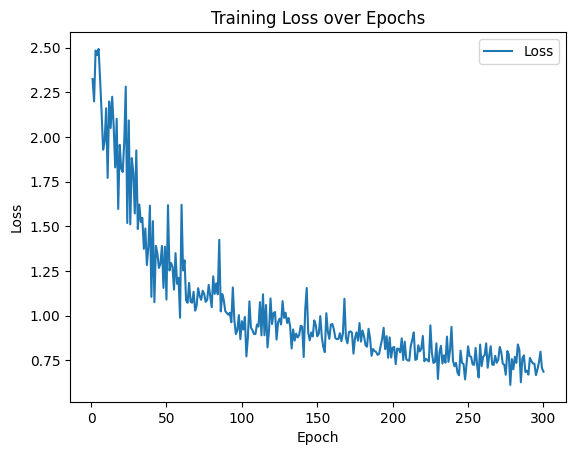

Test Accuracy: 81.43%
      Poisson  DP-Poisson   WR  WOR   MUST.ww MUST.wo MUST.ow
1    2.321009    2.321009  NaN  NaN  2.323559     NaN     NaN
2    2.086199    2.294240  NaN  NaN  2.198563     NaN     NaN
3    2.146337    2.801340  NaN  NaN  2.483495     NaN     NaN
4    2.039199    2.696011  NaN  NaN  2.457732     NaN     NaN
5    1.897972    2.816264  NaN  NaN  2.492308     NaN     NaN
..        ...         ...  ...  ...       ...     ...     ...
296  0.315222    0.807388  NaN  NaN  0.697964     NaN     NaN
297  0.310193    0.990323  NaN  NaN  0.737644     NaN     NaN
298  0.305405    0.852736  NaN  NaN  0.797654     NaN     NaN
299  0.300945    0.841191  NaN  NaN  0.704811     NaN     NaN
300  0.280864    0.858772  NaN  NaN  0.685523     NaN     NaN

[300 rows x 7 columns]


In [ ]:
# Training with WW sampling
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DP_SGD_NN().to(device)

grad_ori, grad_noisy, loss_history, time_record, accuracy = train_DP_SGD(model, train_data, test_loader, stepsize=lr, subsample_method='WW', C=C, TT=TT, eps_prime=eps_prime, b=b, m=m)

final_loss['MUST.ww'] = loss_history
time_record_final["MUST.ww"] = time_record
accuracy_final["MUST.ww"] = accuracy
print(final_loss)

In [ ]:
# Training with WO sampling
# np.random.seed(seed)
# torch.manual_seed(seed)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = DP_SGD_NN().to(device)

# grad_ori, grad_noisy, loss_history, time_record, accuracy = train_DP_SGD(model, train_data, test_loader, stepsize=lr, subsample_method='WO', C=C, TT=TT, eps_prime=eps_prime, b=b, m=m)

# final_loss['MUST.wo'] = loss_history
# time_record_final["MUST.wo"] = time_record
# accuracy_final["MUST.wo"] = accuracy

# print(final_loss)

Epoch 1/300, Loss: 2.3175, grad_diff: -0.0992, time:  2.033415
Epoch 2/300, Loss: 2.2034, grad_diff: -0.0459, time:  1.968644
Epoch 3/300, Loss: 2.4701, grad_diff: 0.0710, time:  2.194528
Epoch 4/300, Loss: 2.5652, grad_diff: -0.0953, time:  2.567962
Epoch 5/300, Loss: 2.5329, grad_diff: -0.0813, time:  2.318271
Epoch 6/300, Loss: 2.0571, grad_diff: -0.0815, time:  1.917477
Epoch 7/300, Loss: 2.3450, grad_diff: 0.0075, time:  1.873363
Epoch 8/300, Loss: 2.0697, grad_diff: 0.0810, time:  2.352653
Epoch 9/300, Loss: 2.1044, grad_diff: -0.0372, time:  2.736113
Epoch 10/300, Loss: 2.4631, grad_diff: -0.0828, time:  2.894713
Epoch 11/300, Loss: 2.3057, grad_diff: -0.1362, time:  2.750230
Epoch 12/300, Loss: 2.3620, grad_diff: -0.1102, time:  1.901851
Epoch 13/300, Loss: 2.0057, grad_diff: -0.0303, time:  1.886169
Epoch 14/300, Loss: 1.8613, grad_diff: 0.1081, time:  1.976598
Epoch 15/300, Loss: 2.3668, grad_diff: 0.0131, time:  1.861831
Epoch 16/300, Loss: 1.7321, grad_diff: 0.1327, time:  

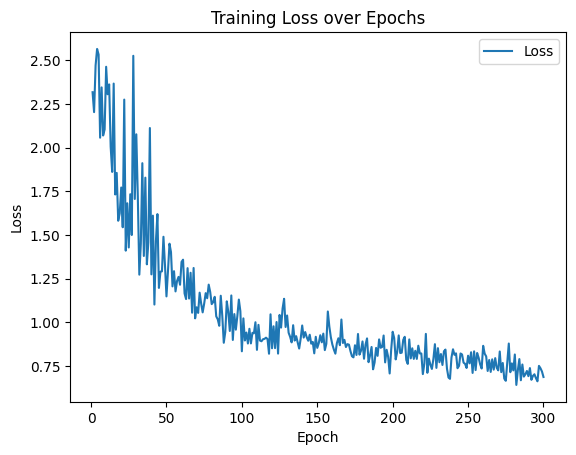

Test Accuracy: 80.09%
      Poisson  DP-Poisson   WR  WOR   MUST.ww MUST.wo   MUST.ow
1    2.321009    2.321009  NaN  NaN  2.323559     NaN  2.317461
2    2.086199    2.294240  NaN  NaN  2.198563     NaN  2.203390
3    2.146337    2.801340  NaN  NaN  2.483495     NaN  2.470142
4    2.039199    2.696011  NaN  NaN  2.457732     NaN  2.565211
5    1.897972    2.816264  NaN  NaN  2.492308     NaN  2.532918
..        ...         ...  ...  ...       ...     ...       ...
296  0.315222    0.807388  NaN  NaN  0.697964     NaN  0.662621
297  0.310193    0.990323  NaN  NaN  0.737644     NaN  0.751029
298  0.305405    0.852736  NaN  NaN  0.797654     NaN  0.737469
299  0.300945    0.841191  NaN  NaN  0.704811     NaN  0.718700
300  0.280864    0.858772  NaN  NaN  0.685523     NaN  0.687336

[300 rows x 7 columns]


In [ ]:
# Training with OW sampling
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DP_SGD_NN().to(device)

grad_ori, grad_noisy, loss_history, time_record, accuracy = train_DP_SGD(model, train_data, test_loader, stepsize=lr, subsample_method='OW', C=C, TT=TT, eps_prime=eps_prime, b=b, m=m)

final_loss['MUST.ow'] = loss_history
time_record_final["MUST.ow"] = time_record
accuracy_final["MUST.ow"] = accuracy

print(final_loss)

Epoch 1/300, Loss: 2.3204, grad_diff: -0.1240, time:  2.573095
Epoch 2/300, Loss: 2.3143, grad_diff: -0.0574, time:  2.690042
Epoch 3/300, Loss: 2.6731, grad_diff: 0.0888, time:  3.742052
Epoch 4/300, Loss: 3.0681, grad_diff: -0.1191, time:  3.740558
Epoch 5/300, Loss: 2.7365, grad_diff: -0.1017, time:  3.218803
Epoch 6/300, Loss: 2.5348, grad_diff: -0.1019, time:  2.611991
Epoch 7/300, Loss: 2.1993, grad_diff: 0.0093, time:  2.540570
Epoch 8/300, Loss: 2.7209, grad_diff: 0.1013, time:  2.549959
Epoch 9/300, Loss: 2.8008, grad_diff: -0.0465, time:  3.263125
Epoch 10/300, Loss: 2.0468, grad_diff: -0.1035, time:  3.339356
Epoch 11/300, Loss: 2.5518, grad_diff: -0.1703, time:  2.556345
Epoch 12/300, Loss: 1.8898, grad_diff: -0.1377, time:  2.612045
Epoch 13/300, Loss: 2.6369, grad_diff: -0.0379, time:  2.660997
Epoch 14/300, Loss: 3.0336, grad_diff: 0.1351, time:  2.959243
Epoch 15/300, Loss: 2.1360, grad_diff: 0.0163, time:  3.627156
Epoch 16/300, Loss: 2.1973, grad_diff: 0.1659, time:  

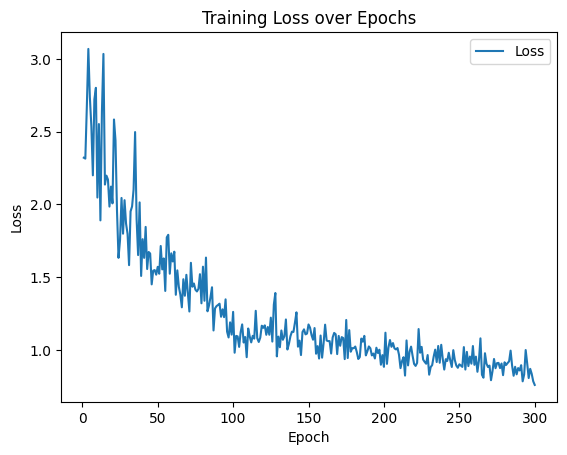

Test Accuracy: 78.60%
      Poisson  DP-Poisson   WR       WOR   MUST.ww MUST.wo   MUST.ow
1    2.321009    2.321009  NaN  2.320415  2.323559     NaN  2.317461
2    2.086199    2.294240  NaN  2.314266  2.198563     NaN  2.203390
3    2.146337    2.801340  NaN  2.673125  2.483495     NaN  2.470142
4    2.039199    2.696011  NaN  3.068066  2.457732     NaN  2.565211
5    1.897972    2.816264  NaN  2.736530  2.492308     NaN  2.532918
..        ...         ...  ...       ...       ...     ...       ...
296  0.315222    0.807388  NaN  0.806445  0.697964     NaN  0.662621
297  0.310193    0.990323  NaN  0.869559  0.737644     NaN  0.751029
298  0.305405    0.852736  NaN  0.835054  0.797654     NaN  0.737469
299  0.300945    0.841191  NaN  0.783982  0.704811     NaN  0.718700
300  0.280864    0.858772  NaN  0.759087  0.685523     NaN  0.687336

[300 rows x 7 columns]


In [ ]:
# Training with WOR sampling
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DP_SGD_NN().to(device)

grad_ori, grad_noisy, loss_history, time_record, accuracy = train_DP_SGD(model, train_data, test_loader, stepsize=lr, subsample_method='WOR', C=C, TT=TT, eps_prime=eps_prime, b=b, m=m)

final_loss['WOR'] = loss_history
time_record_final["WOR"] = time_record
accuracy_final["WOR"] = accuracy

print(final_loss)

Epoch 1/300, Loss: 2.3210, grad_diff: -0.1226, time:  2.660314
Epoch 2/300, Loss: 2.2806, grad_diff: -0.0567, time:  2.510705
Epoch 3/300, Loss: 2.8722, grad_diff: 0.0877, time:  2.599324
Epoch 4/300, Loss: 2.6936, grad_diff: -0.1178, time:  2.549513
Epoch 5/300, Loss: 2.8804, grad_diff: -0.1005, time:  3.491988
Epoch 6/300, Loss: 2.5149, grad_diff: -0.1007, time:  3.177850
Epoch 7/300, Loss: 2.3105, grad_diff: 0.0092, time:  3.550968
Epoch 8/300, Loss: 2.3014, grad_diff: 0.1001, time:  2.618154
Epoch 9/300, Loss: 2.1755, grad_diff: -0.0460, time:  2.845335
Epoch 10/300, Loss: 2.8067, grad_diff: -0.1023, time:  3.640989
Epoch 11/300, Loss: 2.1245, grad_diff: -0.1683, time:  2.629632
Epoch 12/300, Loss: 2.4766, grad_diff: -0.1362, time:  2.508753
Epoch 13/300, Loss: 2.5140, grad_diff: -0.0375, time:  2.553430
Epoch 14/300, Loss: 2.3578, grad_diff: 0.1335, time:  2.610373
Epoch 15/300, Loss: 1.9652, grad_diff: 0.0161, time:  3.380838
Epoch 16/300, Loss: 2.2949, grad_diff: 0.1639, time:  

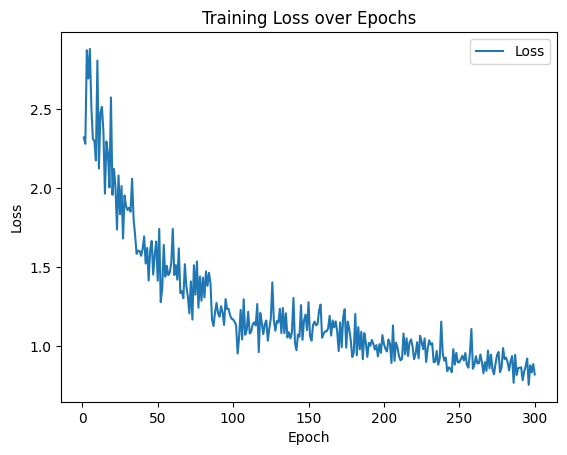

Test Accuracy: 78.92%
      Poisson  DP-Poisson        WR       WOR   MUST.ww MUST.wo   MUST.ow
1    2.321009    2.321009  2.321013  2.320415  2.323559     NaN  2.317461
2    2.086199    2.294240  2.280597  2.314266  2.198563     NaN  2.203390
3    2.146337    2.801340  2.872155  2.673125  2.483495     NaN  2.470142
4    2.039199    2.696011  2.693604  3.068066  2.457732     NaN  2.565211
5    1.897972    2.816264  2.880416  2.736530  2.492308     NaN  2.532918
..        ...         ...       ...       ...       ...     ...       ...
296  0.315222    0.807388  0.756822  0.806445  0.697964     NaN  0.662621
297  0.310193    0.990323  0.880274  0.869559  0.737644     NaN  0.751029
298  0.305405    0.852736  0.835959  0.835054  0.797654     NaN  0.737469
299  0.300945    0.841191  0.888341  0.783982  0.704811     NaN  0.718700
300  0.280864    0.858772  0.822711  0.759087  0.685523     NaN  0.687336

[300 rows x 7 columns]


In [ ]:
# Training with WR sampling
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DP_SGD_NN().to(device)

grad_ori, grad_noisy, loss_history, time_record, accuracy = train_DP_SGD(model, train_data, test_loader, stepsize=lr, subsample_method='WR', C=C, TT=TT, eps_prime=eps_prime, b=b, m=m)

final_loss['WR'] = loss_history
time_record_final["WR"] = time_record
accuracy_final["WR"] = accuracy

print(final_loss)

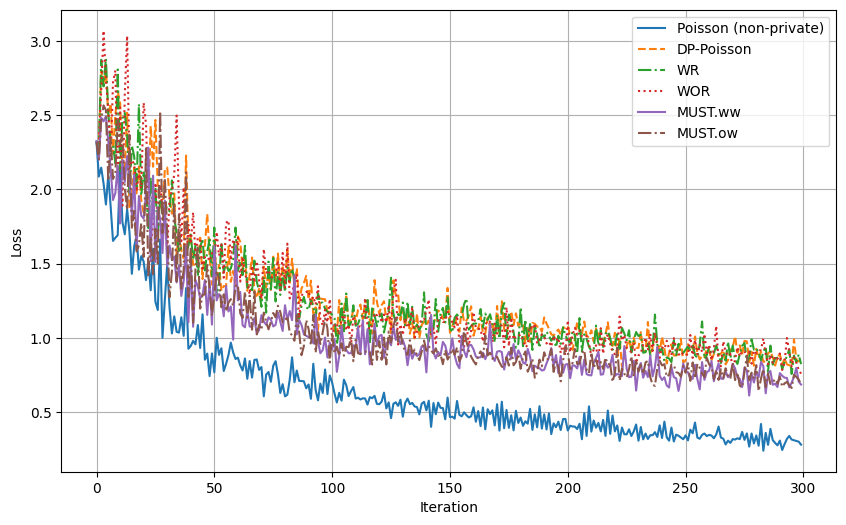

In [ ]:
## For plot
final_loss = pd.read_csv('final_loss.csv')
time_record_final = pd.read_csv('time_record_final.csv')
final_loss.rename(columns={'Poisson': 'Poisson (non-private)'}, inplace=True)

# Plotting the data excluding the 'WO' column
plt.figure(figsize=(10, 6))
line_styles = ['-', '--', '-.', ':', '-', '--', '-.']
for i, col in enumerate(final_loss.columns):
    if col != 'MUST.wo':  # Exclude WO
        plt.plot(final_loss.index, final_loss[col], label=col, linestyle=line_styles[i])

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.savefig('/content/drive/MyDrive/Colab Notebooks/final_loss_plot.pdf')

# Show plot
plt.show()

In [ ]:
print(final_loss)

      Poisson  DP-Poisson        WR       WOR   MUST.ww MUST.wo   MUST.ow
1    2.321009    2.321009  2.321013  2.320415  2.323559     NaN  2.317461
2    2.086199    2.294240  2.280597  2.314266  2.198563     NaN  2.203390
3    2.146337    2.801340  2.872155  2.673125  2.483495     NaN  2.470142
4    2.039199    2.696011  2.693604  3.068066  2.457732     NaN  2.565211
5    1.897972    2.816264  2.880416  2.736530  2.492308     NaN  2.532918
..        ...         ...       ...       ...       ...     ...       ...
296  0.315222    0.807388  0.756822  0.806445  0.697964     NaN  0.662621
297  0.310193    0.990323  0.880274  0.869559  0.737644     NaN  0.751029
298  0.305405    0.852736  0.835959  0.835054  0.797654     NaN  0.737469
299  0.300945    0.841191  0.888341  0.783982  0.704811     NaN  0.718700
300  0.280864    0.858772  0.822711  0.759087  0.685523     NaN  0.687336

[300 rows x 7 columns]


In [ ]:
final_loss.to_csv("final_loss.csv", index = False)
time_record_final.to_csv("time_record_final.csv", index = False)
accuracy_final.to_csv("accuracy_final.csv", index = False)

In [ ]:
stats = {
    'Sum': time_record_final.sum().apply(lambda x: format(x, '.3f')),
    'Mean': time_record_final.mean().apply(lambda x: format(x, '.3f')),
    'Standard Deviation': time_record_final.std().apply(lambda x: format(x, '.3f')),
    'Min': time_record_final.min(),
    'Max': time_record_final.max()
}
pd.DataFrame(stats)

,Sum,Mean,Standard Deviation,Min,Max
Poisson,867.250,2.891,0.397,2.415291,4.119279
DP-Poisson,874.896,2.916,0.396,2.453193,4.563462
WR,862.461,2.875,0.389,2.479084,4.348920
WOR,869.207,2.897,0.407,2.507416,4.258254
MUST.ww,632.022,2.107,0.306,1.803983,3.376954
MUST.wo,0.000,nan,nan,NaN,NaN
MUST.ow,636.651,2.122,0.305,1.819567,3.151567


In [ ]:
print(accuracy_final)

   Poisson  DP-Poisson      WR    WOR  MUST.ww MUST.wo  MUST.ow
0   0.8828      0.7614  0.7892  0.786   0.8143     NaN   0.8009


In [ ]:
print(time_record_final)

NameError: name 'time_record_final' is not defined